## 1. Data Manipulation
### 1.1 Date Convesion Using Python

```python
import pandas as pd
#if keep failing on the coversion of date, then use parse_dates option in padas
data=pd.read_csv(r"C:\Users\DAVID SEO\Desktop\data_practice\Retail_Data_Transactions\Retail_Data_Transactions.csv",parse_dates=["trans_date"])
#exporting the data to the csv file
data.to_csv(r"C:\Users\DAVID SEO\Desktop\data_practice\Retail_Data_Transactions\Retail_Data_Transactions.csv",index=None,header=True)
```


### 1.2 Data Manupulation (SQL)

```sql
WITH user_rfm AS(
   SELECT user_id,
          MAX(SUBSTRING(date,1,10)::DATE) AS dt,--find the latest date a user visited the store
          COUNT(user_id) AS count,
          SUM(amount) as amount
          FROM retail
          GROUP BY user_id
          )
    ,rfm_index AS(
    SELECT user_id,
           '2015-03-30'::DATE-dt AS recency,
           count AS frequency,
           amount AS monetary
           FROM user_rfm)
    ,rfm_ranks AS(
    SELECT --The lower the difference is , the higher the user is ranked. Bear in mind that recency is based on the latest date he/she vists
           --Subtracting 5 could allows the higher ranks to lower value,
           5-FLOOR(CAST((recency-MIN(recency) OVER()+1) AS NUMERIC)/((MAX(recency) OVER()+1-MIN(recency) OVER())/5)) AS recency,
           FLOOR(CAST((frequency-MIN(frequency) OVER()+1) AS NUMERIC)/((MAX(frequency) OVER()+1-MIN(frequency) OVER())/5))+1AS frequency,
           FLOOR(CAST((monetary-MIN(monetary) OVER()+1) AS NUMERIC)/((MAX(monetary) OVER()+1-MIN(monetary) OVER())/5))+1 AS monetary
           FROM rfm_index)
     ,rfm_flag AS(
      SELECT p.idx,
             CASE WHEN r.recency=p.idx THEN 1 ELSE 0 END AS r_flag,
             CASE WHEN r.frequency=p.idx THEN 1 ELSE 0 END AS f_flag,
             CASE WHEN r.frequency=p.idx THEN 1 ELSE 0 END AS m_flag
             FROM rfm_ranks as r
             CROSS JOIN(SELECT GENERATE_SERIES(1,5) AS idx) AS p)
      SELECT idx,
             SUM(r_flag) AS r,
             SUM(f_flag) AS f,
             SUM(m_flag) AS m
             FROM rfm_flag
             GROUP BY idx
             ORDER BY idx DESC;
```






In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

data=pd.read_csv(r"C:\Users\DAVID SEO\Desktop\data_practice\Retail_Data_Transactions\rfm_scatter.csv")
data.head()


,recency,frequency,monetary
0,5,2,3
1,5,2,3
2,5,1,2
3,5,2,2
4,5,2,2


### 2. Data Visualization

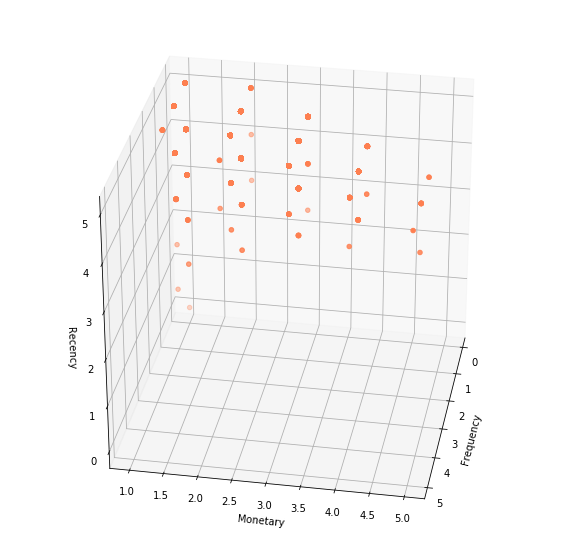

In [2]:

'''
## drawing 3D plots, the following code would raise the error message 
fig,ax=plt.subplots(figsize=(12,5),projection='3d')
'''
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111,projection='3d')
ax.scatter(data.frequency,data.monetary,data.recency,color='coral')
ax.set_xlabel('Frequency')
ax.set_ylabel('Monetary')
ax.set_zlabel('Recency')
ax.view_init(azim=10) #set the rotation angle

The 3D graph shows that a vast number of customers located on the upper high with the number of visits quite lower and the amount of spending not that high. Therefore, we can make a good guess that most consumers have just discovered or rediscovered the store after some time away. The core of the business strategy it should adopt is to build up the long-lasting relation with them. 

The 3 Dimensional representation might not give a clear picture of the consumer segmentation mainly because most observations are either overlapped or even disappear due to the angle of perception and the spatial ordering of bars/points. This all leads to an undesired distortion of graphical representation.  Therefore, we should prepare a table in an organized manner to show the results of each segment.

### 3. preparing a table for conusmer sgemenation

#### 3.1 A table based on  an individual level of each paremeter

```sql
WITH user_rfm AS(
    reference to the above query
          )
    rfm_index AS(
     reference to the above query
   )
    ,rfm_ranks AS(
    - reference to the above query)
    ,rfm_flag AS(
      SELECT p.idx,
             CASE WHEN r.recency=p.idx THEN 1 ELSE 0 END AS r_flag,
             CASE WHEN r.frequency=p.idx THEN 1 ELSE 0 END AS f_flag,
             CASE WHEN r.frequency=p.idx THEN 1 ELSE 0 END AS m_flag
             FROM rfm_ranks as r
             CROSS JOIN(SELECT GENERATE_SERIES(1,5) AS idx) AS p)
      SELECT idx,
             SUM(r_flag) AS r,
             SUM(f_flag) AS f,
             SUM(m_flag) AS m
             FROM rfm_flag
             GROUP BY idx
             ORDER BY idx DESC;
```

In [8]:
#import the result
data=pd.read_csv(r"C:\Users\DAVID SEO\Desktop\data_practice\Retail_Data_Transactions\rfm_3d.csv")
data.set_index("idx") #set idx as index

,r,f,m
idx,,,
5,6056,52,52
4,695,1016,1016
3,119,3183,3183
2,14,2339,2339
1,4,297,297




For the convenience of reading, I prepare a table whose row represents the numbers ranged from 5 to 1  and each column represents those measurements that are used to determine the segmentation of customers. The data store in the table is the number of people in the specific segmentation.




#### 3.2  A table on a total sum of the level of three paramenters

We set up the above table at an individual level of each segment. Instead, let's take the sum of the score of three measurements as an index and place the corresponding counts to each level. 

    

```sql
WITH user_rfm AS(
   SELECT user_id,
          MAX(SUBSTRING(date,1,10)::DATE) AS dt,--find the latest date a user visited the store
          COUNT(user_id) AS count,
          SUM(amount) as amount
          FROM retail
          GROUP BY user_id
          )
    ,rfm_index AS(
    SELECT user_id,
           '2015-03-30'::DATE-dt AS recency,
           count AS frequency,
           amount AS monetary
           FROM user_rfm)
    ,rfm_ranks AS(
    SELECT 
        --The lower the difference is , the higher the user is ranked. Bear in mind that recency is based on the latest date he/she vists
           --Subtracting 5 could allows the higher ranks to lower value,
           user_id,
           5-FLOOR(CAST((recency-MIN(recency) OVER()+1) AS NUMERIC)/((MAX(recency) OVER()+1-MIN(recency) OVER())/5)) AS r,
           FLOOR(CAST((frequency-MIN(frequency) OVER()+1) AS NUMERIC)/((MAX(frequency) OVER()+1-MIN(frequency) OVER())/5))AS f,
           FLOOR(CAST((monetary-MIN(monetary) OVER()+1) AS NUMERIC)/((MAX(monetary) OVER()+1-MIN(monetary)OVER())/5))AS m
           FROM rfm_index)
      SELECT r+f+m AS total_rank,
            r,f,m
            ,count(user_id)
            FROM rfm_ranks
            GROUP BY r,f,m
            ORDER BY r DESC,f DESC,m DESC;
     
```




### 3.3 Simpler representation of RFM analysis

In the previous approach, representing the final result on 3 Dimensions should be somehow burdensome because we need to look at 125 combinations of data. Therefore, there is a need for simplifying our model to depict and understand. In this section we will discuss something in two dimensions. 

In the folloing queries, we will take two parmeters and represent them in two dimensional table. This will reduce the possible combinations from 125 to 50. Combining recency and monetary makes sense in that thay are releated to how much the consumesr is paying
while R on the other axis gives a quick peek(review of) into re-engagement levels with customer. 


```sql
WITH user_rfm AS(
    reference to the above query
          )
    rfm_index AS(
     reference to the above query
   )
    ,rfm_ranks AS(
    - reference to the above query)
    SELECT CONCAT('r_',CAST(r AS TEXT)) AS r_rank,
             COUNT(CASE WHEN f=5 THEN 1 END) AS f_5,
             COUNT(CASE WHEN f=4 THEN 1 END) AS f_4,
             COUNT(CASE WHEN f=3 THEN 1 END) AS f_3,
             COUNT(CASE WHEN f=2 THEN 1 END) AS f_2,
             COUNT(CASE WHEN f=1 THEN 1 END) AS f_1
             FROM rfm_ranks 
             WHERE r>=1
             GROUP BY r
             ORDER BY r DESC;
```


In [7]:
data=pd.read_csv(r"C:\Users\DAVID SEO\Desktop\data_practice\Retail_Data_Transactions\rfm_2d.csv")
data

,r_rank,f_5,f_4,f_3,f_2,f_1
0,r_5,2,49,982,2928,1913
1,r_4,0,3,34,241,345
2,r_3,0,0,0,14,74
3,r_2,0,0,0,0,6
4,r_1,0,0,0,0,1


vast number of customers conglomerated where r is 5 with f either 1 or 2.  This figure alone could help us infer that the retail shop has been currently opened up to attract thier new consumers or has begun to intrigue the attention of customers who are away after some time.
